In [ ]:
# https://docs.exoplanet.codes/en/stable/tutorials/rv/

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using exoplanet. We will follow the getting started tutorial from the excellent RadVel package where they fit for the parameters of the two planets in the K2-24 system.

First, let’s download the data from RadVel:

In [ ]:
import multiprocessing as mp 
mp.set_start_method("fork")

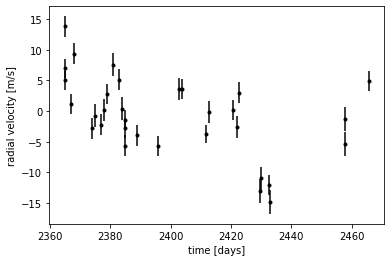

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets from the K2 light curve, so let’s start by using the exoplanet.estimate_semi_amplitude() function to estimate the expected RV semi-amplitudes for the planets.

In [3]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [4]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([1.43643076e-05, 1.41632026e-05])

In [5]:
np.array(period_errs) / np.array(periods)

array([1.43643076e-05, 1.41632026e-05])

The radial velocity model in PyMC3
Now that we have the data and an estimate of the initial values for the parameters, let’s start defining the probabilistic model in PyMC3 (take a look at A quick intro to PyMC3 for exoplaneteers if you’re new to PyMC3). First, we’ll define our priors on the parameters:

In [6]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19(
        "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    )

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

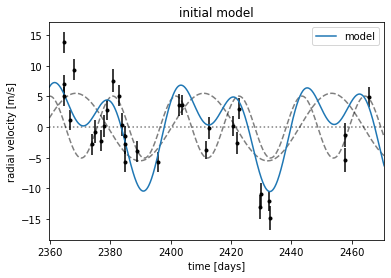

In [7]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn’t look amazing so let’s fit for the maximum a posterior parameters.

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]



message: Optimization terminated successfully.
logp: -68.03907701822229 -> -57.42134937391678
optimizing logp for variables: [logs, logP, logK, trend, t0]



message: Optimization terminated successfully.
logp: -57.42134937391678 -> -51.81968815504227
optimizing logp for variables: [ecs]



message: Optimization terminated successfully.
logp: -51.81968815504227 -> -50.935595393271335
optimizing logp for variables: [trend, logs, ecs, logK, logP, t0]


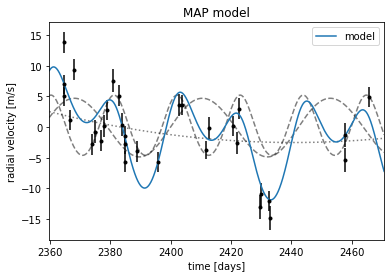

In [9]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

Sampling
Now that we have our model set up and a good estimate of the initial parameters, let’s start sampling. There are substantial covariances between some of the parameters so we’ll use the pmx.sample function from pymc3-ext which wraps pm.sample function with some better defaults and tuning strategies.

In [10]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

/Users/josephkarpinski/opt/anaconda3/envs/env385exoplanet/lib/python3.8/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, ecs, logK, logP, t0]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 89 seconds.


After sampling, it’s always a good idea to do some convergence checks. First, let’s check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [11]:
import arviz as az

az.summary(
    trace, var_names=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

/Users/josephkarpinski/opt/anaconda3/envs/env385exoplanet/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.001,0.002,0.000,0.000,10703.0,5478.0,1.0
trend[1],-0.041,0.024,-0.085,0.004,0.000,0.000,11084.0,5743.0,1.0
trend[2],-1.844,0.802,-3.343,-0.334,0.008,0.006,10117.0,5285.0,1.0
logs,1.122,0.209,0.726,1.511,0.003,0.002,6071.0,5003.0,1.0
omega[0],-0.013,1.198,-2.290,2.698,0.014,0.010,7919.0,6860.0,1.0
omega[1],-0.334,1.964,-3.105,2.864,0.023,0.016,7327.0,7387.0,1.0
ecc[0],0.085,0.089,0.000,0.276,0.002,0.001,2824.0,3662.0,1.0
ecc[1],0.049,0.060,0.000,0.114,0.001,0.001,3459.0,2249.0,1.0
t0[0],2072.795,0.001,2072.793,2072.796,0.000,0.000,12639.0,5908.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,11563.0,5772.0,1.0


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime…

Then we can make a corner plot of any combination of the parameters. For example, let’s look at period, semi-amplitude, and eccentricity:

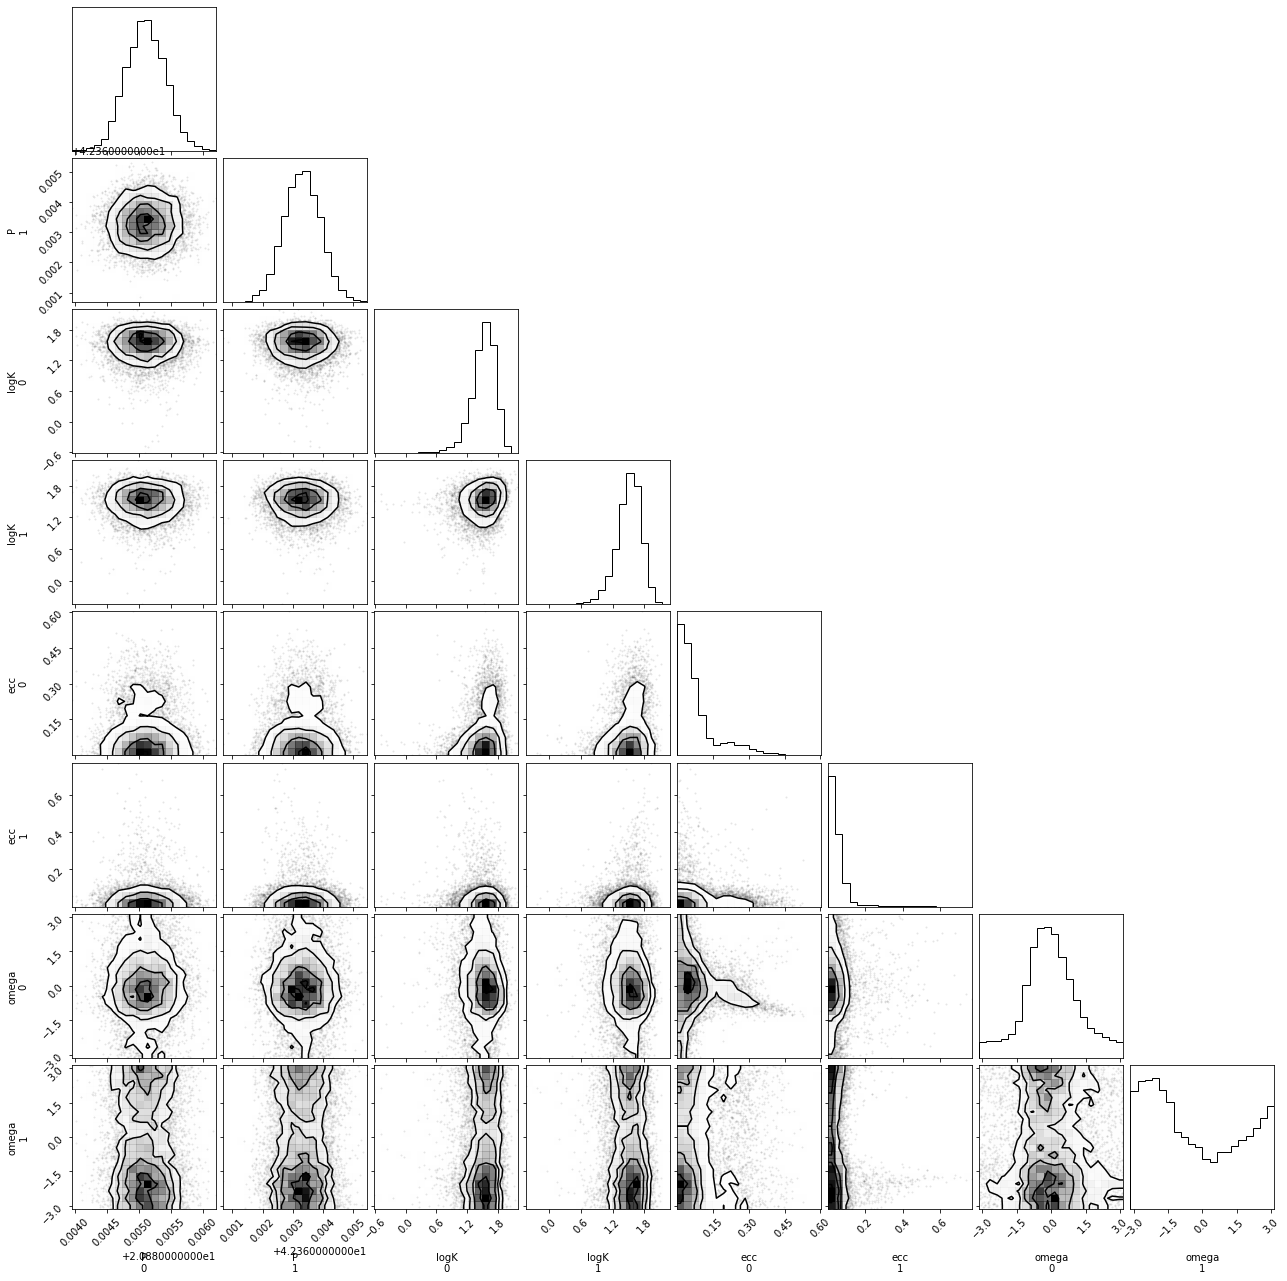

In [12]:
import corner

with model:
    _ = corner.corner(trace, var_names=["P", "logK", "ecc", "omega"])

Finally, let’s plot the plosterior constraints on the RV model and compare those to the data:

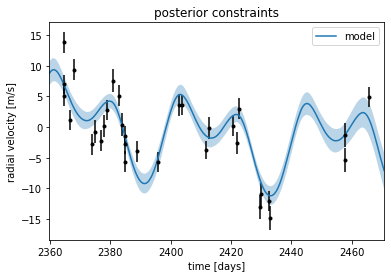

In [13]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

In [ ]:
Phase plots
It might be also be interesting to look at the phased plots for this system. Here we’ll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

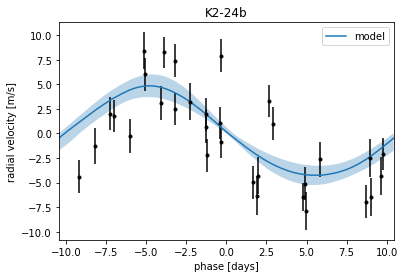

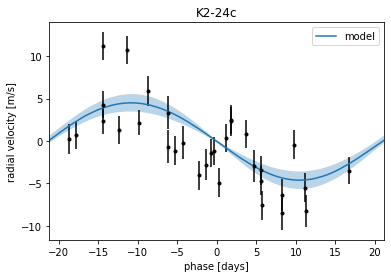

In [14]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))